Accuracy: 0.7898


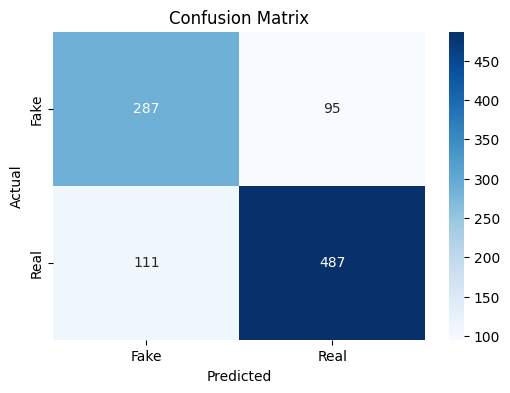

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Step (a): Load and Vectorize Data
def load_data(real_file='dataset/real.txt', fake_file='dataset/fake.txt'):
    with open(real_file, 'r', encoding='utf-8') as f:
        real_news = f.readlines()
    with open(fake_file, 'r', encoding='utf-8') as f:
        fake_news = f.readlines()
    
    labels = np.array([1] * len(real_news) + [0] * len(fake_news))  # 1 for real, 0 for fake
    texts = np.array(real_news + fake_news)
    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)  # Convert text to numerical feature vectors
    
    return X, labels, vectorizer, texts

# Step (b): Remove Uninformative Words
def filter_words(X, vectorizer, texts, min_freq=0.005, max_freq=0.7):
    total_samples = X.shape[0]
    word_freq = np.array((X > 0).sum(axis=0)).flatten() / total_samples
    
    mask = (word_freq > min_freq) & (word_freq < max_freq)
    filtered_features = np.array(vectorizer.get_feature_names_out())[mask]
    
    new_vectorizer = CountVectorizer(vocabulary=filtered_features)
    X_filtered = new_vectorizer.fit_transform(texts)
    
    return X_filtered, new_vectorizer

# Step (c): Implement Naïve Bayes Classifier
def naive_bayes_train(X_train, y_train):
    total_real = np.sum(y_train == 1)
    total_fake = np.sum(y_train == 0)
    
    prior_real = total_real / len(y_train)
    prior_fake = total_fake / len(y_train)
    
    real_counts = np.array(X_train[y_train == 1].sum(axis=0)).flatten() + 1  # Laplace smoothing
    fake_counts = np.array(X_train[y_train == 0].sum(axis=0)).flatten() + 1
    
    total_words_real = real_counts.sum()
    total_words_fake = fake_counts.sum()
    
    likelihood_real = real_counts / total_words_real
    likelihood_fake = fake_counts / total_words_fake
    
    return prior_real, prior_fake, likelihood_real, likelihood_fake

# Step (c): Predict using Naïve Bayes
def naive_bayes_predict(X_test, prior_real, prior_fake, likelihood_real, likelihood_fake):
    log_prob_real = X_test @ np.log(likelihood_real) + np.log(prior_real)
    log_prob_fake = X_test @ np.log(likelihood_fake) + np.log(prior_fake)
    return (log_prob_real > log_prob_fake).astype(int)

# Load Data
X, y, vectorizer, texts = load_data()
X, vectorizer = filter_words(X, vectorizer, texts)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Model
prior_real, prior_fake, likelihood_real, likelihood_fake = naive_bayes_train(X_train, y_train)

# Predict on Test Set
y_pred = naive_bayes_predict(X_test, prior_real, prior_fake, likelihood_real, likelihood_fake)

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix Visualization
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
